# CNN model to classify handwritten digits

## Abstract
  - Project demonstrates the development of a high performance Convoluted Neural Network (CNN).
  - Model classifies handwritten digits from MNIST dataset.
  - A high accuracy and F1 model was achieved. (Score: 0.9889 respectively)
  - High performance achieved with **shallow CNN** and **10 training epochs**.
    - Shallow CNN: 3 CNN layers plus 2 FCN layers.
    - 10 training epochs:
      - 60,000 training samples (standard size)
      - Trained with 5 folds
      - Mini-batch size of 32
      - Total iterations: 18,750
  - This project also showcases good capability for pipeline and workflow development.

## Project description
   
**Aims:** 
  - Train CNN model to classify handwritten digits from 2D images.
  - Validate and optimise model.
  - Achieve high accuracy and F1 for classification. 

**Background:**
  - Images are grayscale 28 x 28 = 784 matrix image.
  - Image source: MNIST dataset in TorchVision.
  - Images are scans from handwritten digits.
  - Every handwritten digit has many variations. e.g.:
    - contrast varation from writing ink pressure
    - angle variation from slanted writing
    - size variation from personal writing style

**Modelling Strategy:**
_(In chronological order)_

  - Compress image data resolution by 255 times to improve training and classification time.
  - Design different CNN models.
  - Train and validate on train dataset (n = 60,000).
  - To minimise overfitting, use mini batch input.
  - Validation approach:
    - Handwriting has high variation.
    - Good accuracy validation should test model to high variety of data. 
    - Use K-fold to simulate testing for accuracy on a variety of dataset. 
        - For accurate comparison across folds, re-initialise model and loss optimiser in each fold.
        - This is to prevent learnt weights and loss gradients from leaking across K-folds.
        - Pick model with best mean fold loss and lowest standard deviation 
    - Fine-tune model hyperparameters using grid-search.
  - Further prevent overfitting. Reset fine-tuned model for training. 
  - Further minimise overfitting by exposing model to more data variety:
    - Use K-fold to increase variety of data exposed.
    - This effectively batches what the model learns from each dataset.
    - Perform data augmentation (e.g. image rotation, image contrast, etc.) on training dataset to improve training variety.
  - Explore model performance on test dataset (n = 10,000).
  - (If needed) further fine-tune model, retrain and validate.
  - Modelling complete


## Import packages

In [1]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sn
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd


## Option to load tensor to CUDA / CPU

In [2]:
print(f"cuda available = {torch.cuda.is_available()}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## use CPU only; optional code to use CPU only calculation
# device = torch.device("cpu") 
  

cuda available = True


## Load dataset into tensor

**Notes:**
- Both train and test dataset are transformed into tensors
- To minimise overfitting, in subsequent steps, train dataset will receive data augementation.
- Test dataset will not receive any data augmentation. (This is to test model's real performance)

In [3]:
## Option to download dataset
# download = True 
download = False

## Transform
## (Resolution compression and data augmentation is done later)
transform = v2.Compose([v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True)])
train_dataset = MNIST(root = 'data', train = True, transform = transform, download = download)

## Transform test data into Tensor. No further transformation. 
## (Except resolution compression. This is done later)
test_dataset = MNIST(root = 'data', train = False, transform = transform, download = download)



## Training and k-fold validation wrapper function
### (with model reset in each fold) 
### In each fold, calls function to train and validate at each epoch 

**Design considerations:** 
  - To test and compare model design accuracy aross different datasets, model and loss optimisers were reset for every training fold.
  - This prevents learnt weights and gradients from leaking across folds.
  - Other methods employed to prevent leaks:
      - K-fold without replacement
      - Each fold has its own training and validation data subsets to prevent leaking.
      - Data augmentation of training dataset was only conducted for each fold's training data subset.
      - Data augmentation not performed on each folds's validaiton data subset.
      - Augmentation parameters were optimised in separate experiment. (Separate experiment not shown here)  

**Design validation included. Compare training v.s. validation**
  - Total losses for each epoch measured as the mean loss per image.
  - For model comparision, metrics measured in each fold:
      - Accuracy, mean losses and loss standard deviation.
      - Metric compared against number of epochs.

In [4]:
## Function to train model and do k-fold validation (with model reset in each fold) 

def kFoldTrainVsVal(model, 
                    k, 
                    dataset, 
                    batch_size, 
                    epochs, 
                    optimiser, 
                    loss_fn, 
                    config_dict,
                    optimiser_lr,
                    optimiser_weight_decay):
    
    kf = KFold(n_splits=k, shuffle=True, random_state=None)    
    
    ## List to store train and evaluate losses from each fold
    fold_loss_lst = []

    ## Initialise accumulator
    total_evaluate_loss = 0
    fold_count = 0

    ## Print k fold header
    print()
    print(f"{k}-fold Cross-Validation")
    
    for train_index, evaluate_index in kf.split(dataset):

        ## Re-initialise model to prevent leakage across k-folds
        ## Use the haprerparamter settings from dict
        sub_config_dict = {}
        for key, value in config_dict.items():
                if 'optim' not in key: 
                    sub_config_dict[key] = value

        model = CNN(**sub_config_dict)
        
        ## NOTE AS AT MARCH 2024:
        ## Pytorch doesn't reset Adam's learning rate momentum if optimiser.zero_grad() is used
        ## To conduct proper k-fold and prevent the learning rate momentum from leaking across folds
        ## Re-create the optimiser manually
        optimiser = optim.Adam(model.parameters(), lr = optimiser_lr, weight_decay = optimiser_weight_decay)
        
        train_subset = torch.utils.data.Subset(dataset, train_index)
        evaluate_subset = torch.utils.data.Subset(dataset, evaluate_index)
         
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        evaluate_loader = DataLoader(evaluate_subset, shuffle=True)

        ## Print fold header
        print()
        fold_count += 1
        print(f"Cross-validating fold: {fold_count}")

        ## Initialise list to store mean losses per epoch
        mean_train_loss_per_epoch_lst = []
        mean_evaluate_loss_per_epoch_lst = []

        ## Initialise list to store accuracy per epoch
        accuracy_lst = []

        ## Get fold train and evaluate losses
        fold_train_eval = trainVsEvalModel(model, 
                                           train_loader, 
                                           epochs, 
                                           optimiser,
                                           loss_fn,
                                           mean_train_loss_per_epoch_lst, 
                                           evaluate_loader, 
                                           mean_train_loss_per_epoch_lst,
                                           accuracy_lst,
                                           fold_count)
        
        fold_train_loss, fold_evaluate_loss = fold_train_eval

        fold_loss_lst.append((fold_train_loss, fold_evaluate_loss))

    ## Print final summary
    print()
    print("K-Fold Cross-Validation Summary:")

    fold_evaluate_loss_lst = []
    for fold, (train_loss, val_loss) in enumerate(fold_loss_lst):
        print(f"Fold {fold+1}: Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        total_evaluate_loss += fold_evaluate_loss
        fold_evaluate_loss_lst.append(val_loss)

    mean_kfold_evaluate_loss = total_evaluate_loss / k
    std_kfold_evaluate_loss = np.std(fold_evaluate_loss_lst, ddof = k-1)    

    return mean_kfold_evaluate_loss, std_kfold_evaluate_loss



## Wrapper epoch function 
### Called to setup model training and evaluate per epoch

**Notes:**
  - **Data augmentation** performed here.
    - Note that data augmentation is only called on training data subset used here. Prevents data leakage.
  - Note that training data's image resolution compressed by 255 times to improve training time.

**Pipeline wrapper to call metrics generator**  
  - Calls function to print loss and accuracy metric over epoch.
  - Metrics are used in later steps to inform selection of epoch and other hyperparameters.


In [5]:
## Setup model training and evaluate per epoch

def trainVsEvalModel(model,
                     train_dataset, 
                     epochs, 
                     optimiser, 
                     loss_fn, 
                     mean_train_loss_per_epoch_lst, 
                     evaluate_dataset, 
                     mean_evaluate_loss_per_epoch_lst, 
                     accuracy_lst,
                     fold_count):

    ## Load model to device
    model.to(device)

    ## Do train
    model.train()
    
    ## Print some hyperparameters for this model
    print(f"Epoch = {epochs}")
    print(f"Batch size = {batch_size}")

    ## Print headers for epoch metrics
    print('Epoch', 
          'Train Loss', 
          'Validate Loss', 
          'Validation Accuracy', 
          sep='\t')
    print('-----', 
          '----------', 
          '-------------', 
          '-------------------', 
          sep='\t')
    
    ## Iterate epochs
    for epoch in range(1, epochs+1):

        ## Initialise total loss for train
        train_total_loss = 0
        
        for x_train, y_train in train_dataset:
         
            ## Reduce grayscale resolution
            x_train = x_train / 255
            
            ## Augmentation and transform
            transform = v2.Compose([v2.RandomRotation(12),
                                    v2.RandomAffine(degrees=12, translate=(0.05,0.05), shear=(12,12,12,12), scale=(0.95, 1.05)),
                                    v2.ColorJitter(brightness=0.05, contrast=0.05),
                                    v2.RandomAdjustSharpness(1.05, p=0.20)
                                   ])

            ## Load x, y train variables
            x_train = transform(x_train)
            x_train, y_train = x_train.to(device), y_train.to(device)
            
            ## Create weights and calculate loss
            optimiser.zero_grad()
            y_pred_train = model(x_train)
            train_loss = loss_fn(y_pred_train, y_train)
            train_loss.backward()
            optimiser.step()

            train_total_loss += train_loss.item()
        
        ## Record mean train loss per digit image per epoch
        len_train = len(train_dataset)            
        mean_train_loss_per_epoch = train_total_loss/len_train
        
        ## Copy list to prevent aliasing with other evaluate list. Seems to be a pytorch issue
        mean_train_loss_per_epoch_lst = mean_train_loss_per_epoch_lst[:]
        
        mean_train_loss_per_epoch_lst.append(mean_train_loss_per_epoch)
        
        ## Copy list to prevent aliasing with other evaluate list. Seems to be a pytorch issue
        mean_train_loss_per_epoch_lst = mean_train_loss_per_epoch_lst[:]

        ## Do evaluate
        accuracy, mean_evaluate_loss, true_lst, predictions_lst = evalModel(model, evaluate_dataset, loss_fn)
        
        ## Record mean evaluate loss per digit image per epoch
        ## Copy list to prevent aliasing with other train list. Seems to be a pytorch issue
        mean_evaluate_loss_per_epoch_lst = mean_evaluate_loss_per_epoch_lst[:]
        mean_evaluate_loss_per_epoch = mean_evaluate_loss

        ## Copy list to prevent aliasing with other train list. Seems to be a pytorch issue
        mean_evaluate_loss_per_epoch_lst.append(mean_evaluate_loss_per_epoch)
        mean_evaluate_loss_per_epoch_lst = mean_evaluate_loss_per_epoch_lst[:]

        ## Record accuracy for epoch
        ## Copy list to prevent aliasing across folds. Seems to be a pytorch issue
        accuracy_lst = accuracy_lst[:]
        accuracy_lst.append(accuracy) 
        ## Copy list to prevent aliasing across folds. Seems to be a pytorch issue
        accuracy_lst = accuracy_lst[:]
        
        ## Print mean train and evaluate loss values per digit image at epoch_interval of epoch intervals
        epoch_interval = 1
        if epoch % epoch_interval == 0:
            print(f"{epoch:>5d}", 
                  f"{mean_train_loss_per_epoch:>.5f}   ", 
                  f"{mean_evaluate_loss_per_epoch:>.5f}      ", 
                  f"{(accuracy*100):>.3f} %           ", 
                  sep='\t')
            
    ## Plot Validation - Mean Training v.s. Validation Loss per Epoch
    super_title = f'Cross-validation of fold: {fold_count}'
    # print(mean_train_loss_per_epoch_lst)
    # print(mean_evaluate_loss_per_epoch_lst)
    plotTrainEvalLine(mean_train_loss_per_epoch_lst, mean_evaluate_loss_per_epoch_lst, super_title)
    
    ## Function to plot validation accuracy per epoch
    plotValAccuLine(accuracy_lst, super_title)

    ## Function to plot evaluate predictions and true scatter plot
    plotConfusionMatrix(len(true_lst), true_lst, predictions_lst, super_title)

    ## Obtain mean train and evaluate loss per digit image 
    mean_train_loss_per_digit_image = sum(mean_train_loss_per_epoch_lst)
    mean_evaluate_loss_per_digit_image = sum(mean_evaluate_loss_per_epoch_lst)

    return  (mean_train_loss_per_digit_image, mean_evaluate_loss_per_digit_image)


## Function called for validation and metric reporting  

**Design considerations:**
  - Note that data augmentation is not called on validation data subset used here. Prevents data leakage.
  - Note that validation data's image resolution compressed by 255 times to improve classification time


In [6]:
## Setup validation function 

def evalModel(model, evaluate_dataset, loss_fn):
    ## Do evaluation
    model.eval()
    
    ## Initialise accumulators
    evaluate_total_loss = 0
    correct_count = 0
    
    ## Initialise lists for plot confusion matrix of evaluate true v.s. predictions
    predictions_lst = []
    true_lst = []
        
    ## Don't calculate gradients to save memory
    with torch.no_grad():
    
        ## Loop through dataset
        for x_evaluate, y_evaluate in evaluate_dataset:
            
            ## Reduce grayscale resolution
            x_evaluate = x_evaluate / 255
    
            ## Load x, y train variables
            x_evaluate, y_evaluate = x_evaluate.to(device), y_evaluate.to(device)
    
            ## Calculate loss
            y_pred_evaluate = model(x_evaluate)
            evaluate_loss = loss_fn(y_pred_evaluate, y_evaluate)
            evaluate_total_loss += evaluate_loss.item() 
    
            ## Calculate the accuracy of predictions vs y_validation    
            _, predicted = torch.max(y_pred_evaluate, 1)
            correct_count += (predicted == y_evaluate).sum().item()

            ## For plot confusion matrix of evaluate true v.s. predictions
            ## Copy list to prevent aliasing the other list. Seems to be a pytorch issue
            true_lst = true_lst[:]
            
            true_lst.append(y_evaluate.cpu())
            
            ## Copy list to prevent aliasing the other list. Seems to be a pytorch issue
            true_lst = true_lst[:]

            ## Copy list to prevent aliasing the other list. Seems to be a pytorch issue
            predictions_lst = predictions_lst[:]
            
            predictions_lst.append(predicted.cpu())
            
            ## Copy list to prevent aliasing the other list. Seems to be a pytorch issue
            predictions_lst = predictions_lst[:]
    
    ## Calculate evaluate accuracy
    evaluate_count = len(evaluate_dataset.dataset)
    accuracy = correct_count / evaluate_count

    ## Record mean evaluate loss per digit image
    mean_evaluate_loss = evaluate_total_loss/evaluate_count

    return accuracy, mean_evaluate_loss, true_lst, predictions_lst



## Functions to generate graphs for evaluation / validation

In [7]:
## Function to plot train and evaluate loss per epoch
def plotTrainEvalLine(mean_train_loss_per_epoch_lst, mean_evaluate_loss_per_epoch_lst, name):
    print()
    fig, ax = plt.subplots()
    
    epochs_lst = np.arange(1, len(mean_train_loss_per_epoch_lst) + 1)
    train_loss_lst = mean_train_loss_per_epoch_lst
    evaluate_loss_lst = mean_evaluate_loss_per_epoch_lst
    
    ax.plot(epochs_lst, train_loss_lst, label='Training loss')
    ax.plot(epochs_lst, evaluate_loss_lst, label='Validation loss')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Mean loss per digit image')

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.suptitle(f'{name}', weight='bold')
    ax.set_title('Mean Training v.s. Validation Loss per Epoch', weight='bold')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Function to plot validation accuracy per epoch
def plotValAccuLine(accuracy_lst, name):
    print()
    fig, ax = plt.subplots()
    
    epochs_lst = np.arange(1, len(accuracy_lst) + 1)
    
    ax.plot(epochs_lst, accuracy_lst, label='Validation accuracy')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.suptitle(f'{name}', weight='bold')
    ax.set_title('Accuracy per Epoch', weight='bold')
    ax.legend()

    plt.tight_layout()
    plt.show()
    
## Function to plot confusion matrix of evaluate true v.s. predictions
def plotConfusionMatrix(len_dataset, true_lst, predictions_lst, name):
    print()

    ## Build classes for each digit
    classes = tuple([i for i in range(10)])
    
    ## Build confusion matrix
    cf_matrix = confusion_matrix(true_lst, predictions_lst)
    dataframe_cf_matrix = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], 
                                       index = [i for i in classes],
                                       columns = [i for i in classes])
    

    plt.figure(figsize = (12,7))
    sn.heatmap(dataframe_cf_matrix, annot=True)
    plt.xlabel('Predicted digits')
    plt.ylabel('True digits')
    
    plt.suptitle(f'{name}', weight='bold')
    plt.title("Confusion matrix of true v.s. predicted digit", weight='bold')
    
    plt.tight_layout()
    plt.show()




## Wrapper function to test multiple model hyperparameter configs
### Configs tested using k-fold train-evaluation 

In [8]:
## Function to drive training and k-fold validation of multiple hyperparamter config on same model skeleton

def multiConfigTrainEvalModel(dataset, k, batch_size, epochs, config_master_lst):
    for config_dict in config_master_lst:
        print()
        print(f"Hyperparamaters == {config_dict}")
    
        ## For reference only. Acutal model with settings will be called in each fold
        sub_config_dict = {}
        for key, value in config_dict.items():
            if 'optim' not in key: 
                sub_config_dict[key] = value
         
        model = CNN(**sub_config_dict)
        
        optimiser_lr = config_dict['optimiser_lr']
        optimiser_weight_decay = config_dict['optimiser_weight_decay']
        
        optimiser = optim.Adam(model.parameters(), 
                               lr = optimiser_lr, 
                               weight_decay = optimiser_weight_decay)
    
        loss_fn = nn.CrossEntropyLoss()
    
        
        ## Mean and std loss for k folds
        mean_kfold_evaluate_loss, std_kfold_evaluate_loss = kFoldTrainVsVal(model, 
                                                                            k, 
                                                                            dataset, 
                                                                            batch_size, 
                                                                            epochs, 
                                                                            optimiser, 
                                                                            loss_fn, 
                                                                            config_dict,
                                                                            optimiser_lr,
                                                                            optimiser_weight_decay)
        
        ## Summary of k fold validation 
        print()
        print(f"Mean validation loss across {k} folds: {mean_kfold_evaluate_loss:.5f}")
        print(f"Standard deviation of validation loss across {k} folds: {std_kfold_evaluate_loss:.5f}")
        print()



## Construction of CNN architecture

**Coding notes:**
  - In below architecture, we test different dropout configurations to reduce overfitting, without underfitting.
  - For the code, hyperparameters are designed as variables.
  - Variables take in settings from a hyperparameter dictionary.
  - This supports streamlined testing workflow.
  - I.e. Store different settings in a sequence. Then test model in a series of different settings.

**Intuition for the CNN architecture design**
  - General CNN architecture:
    1) CNN Layer 1: Capture general characteristics from the image
        1) Wider kernel to capture general details
        2) Base number of features for general feature abastraction 
    2) CNN Layer 2: Differentiate the data. Increase the details learnt from previous layer
        1) Smaller kernel to learn more weights
        2) More features to increase abstraction
    3) CNN Layer 3: Consolidate details learnt into general features for classification
        1) Transpose convolution. Use larger kernel and less features to generalise
    4) Summarise the features to get most defining features. Avoid overfitting
        1) Downsample with max pooling
    5) FCN Layers: Interpret CNN information for final classification.   

**Other design considerations:**
  - Batch normalisation is used in every CNN layer to reduce overfitting by stabilising output.
  - ReLU is used in every CNN and FCN layer to activate relevant nodes.
  - Log Softmax selected for higher performance of correctly activating the neuron for final output . 
  - Number of layers, features and activation function determined in a seperate experiment. (Not shown here.)
  - Mini batch size of 32 used for training.
    - Size selected to reduce overfitting.
    - Selection based on:
      - literature
      - conventional optimisation starting size
      - validated performance. (Validation of size '32' not shown here)

In [9]:
## Setup CNN model skeleton

class CNN(nn.Module):
    def __init__(self, 
                 conv_layer_drop0,
                 conv_layer_drop1,
                 conv_layer_drop2,
                 fc_layer_fdrop0,
                 fc_layer_fdrop1):
        
        super(CNN, self).__init__()
 
        self.conv0 = nn.Sequential(nn.Conv2d(1, 40, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU(inplace = False),
                                   nn.Dropout(p = conv_layer_drop0),
                                   nn.BatchNorm2d(40),
                                   
                                   nn.Conv2d(40, 160, kernel_size=2, stride=1, padding=1),
                                   nn.ReLU(inplace = False),
                                   nn.Dropout(p = conv_layer_drop1),
                                   nn.BatchNorm2d(160),
                                   
                                   nn.Conv2d(160, 40, kernel_size=2, stride=2, padding=1),
                                   nn.ReLU(inplace = False),
                                   nn.Dropout(p = conv_layer_drop2),
                                   nn.BatchNorm2d(40),
                                   
                                   nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
                                   )

        self.fc_layer_fdrop0 = fc_layer_fdrop0
        self.fc_layer_fdrop1 = fc_layer_fdrop1

        self.fc0 = nn.Linear(1960, 490)
        self.fc1 = nn.Linear(490, 10)
    
        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.conv0(x)
        
        ## Flatten
        x = x.view(x.size(0), -1)  
        
        x = nn.functional.relu(self.fc0(x), inplace=False)
        x = nn.functional.dropout(x, training = self.fc_layer_fdrop0[0], p = self.fc_layer_fdrop0[1])
    
        x = nn.functional.relu(self.fc1(x), inplace=False)
        x = nn.functional.dropout(x, training = self.fc_layer_fdrop1[0], p = self.fc_layer_fdrop1[1])
        
        return self.logsoftmax(x)



## Evaluating various CNN hyperparameter configs 
### Training and K-fold validation  

**Notes:**
  - As this project is to demo pipeline capability, a low K is used to save on processing time. (K = 2)
  - In literature, the smallest K used is usually K = 5. Ideally the project used at least K = 5.

### Hyperparameter designs: 
#### Dropout at every CNN and FCN layer 
#### v.s. No dropouts


Hyperparamaters == {'optimiser_lr': 1e-05, 'optimiser_weight_decay': 0.0001, 'conv_layer_drop0': 0.2, 'conv_layer_drop1': 0.2, 'conv_layer_drop2': 0.2, 'fc_layer_fdrop0': (True, 0.2), 'fc_layer_fdrop1': (True, 0.2)}

2-fold Cross-Validation

Cross-validating fold: 1
Epoch = 5
Batch size = 32
Epoch	Train Loss	Validate Loss	Validation Accuracy
-----	----------	-------------	-------------------
    1	2.30426   	2.31184      	10.120 %           
    2	1.93904   	1.32845      	58.957 %           
    3	1.26878   	1.10644      	65.193 %           
    4	1.16305   	1.03685      	67.207 %           
    5	1.07756   	0.99457      	68.737 %           



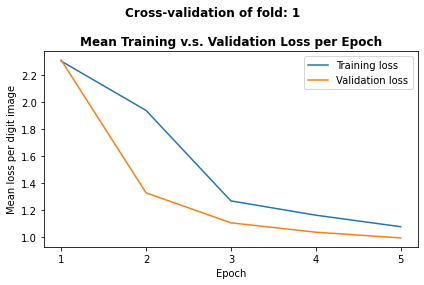

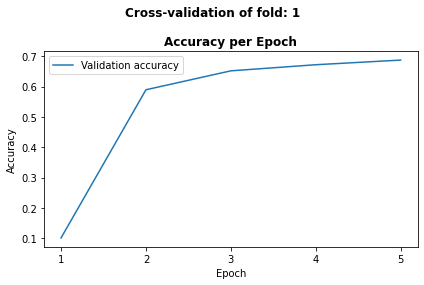

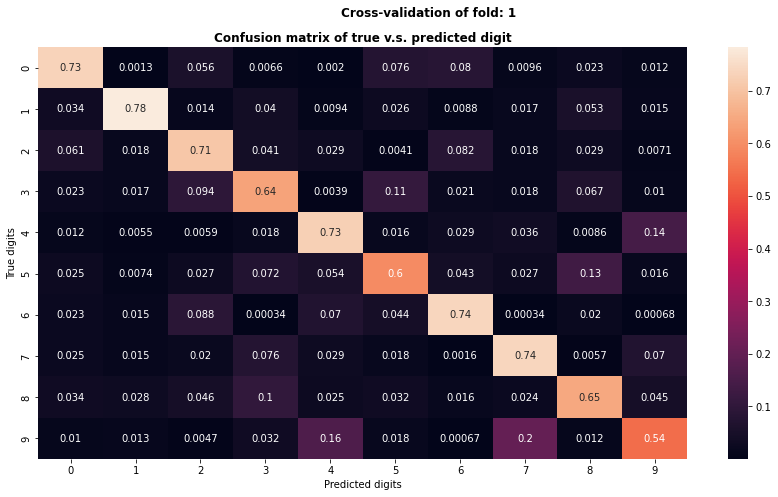


Cross-validating fold: 2
Epoch = 5
Batch size = 32
Epoch	Train Loss	Validate Loss	Validation Accuracy
-----	----------	-------------	-------------------
    1	2.30380   	2.31279      	10.153 %           
    2	2.29162   	2.25765      	21.013 %           
    3	2.02022   	1.65340      	52.927 %           
    4	1.53336   	1.33172      	57.923 %           
    5	1.35422   	1.17632      	63.223 %           



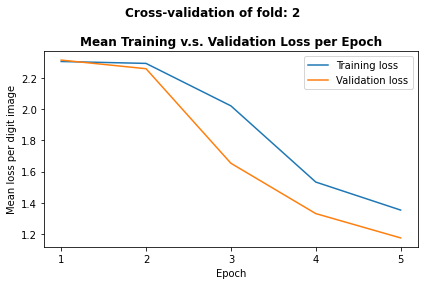

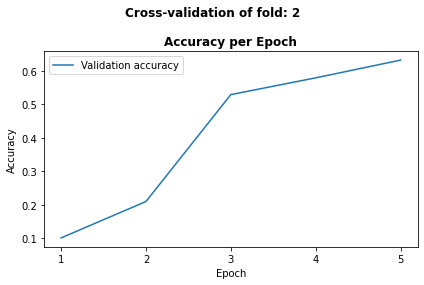

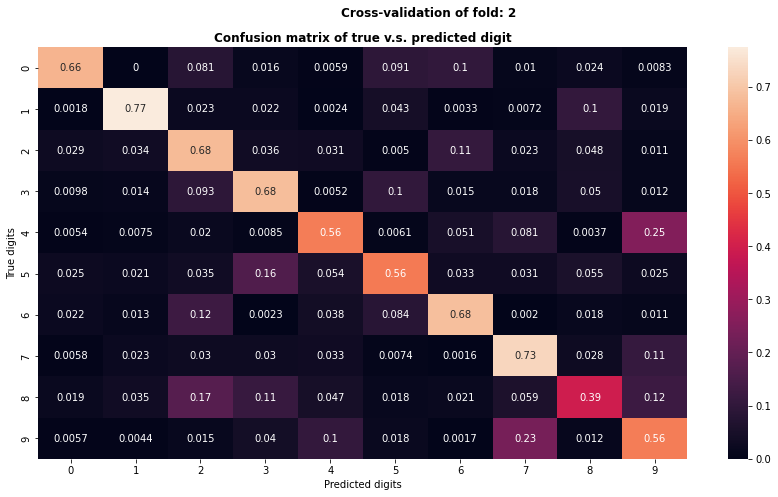


K-Fold Cross-Validation Summary:
Fold 1: Training Loss: 7.7527, Validation Loss: 6.7782
Fold 2: Training Loss: 9.5032, Validation Loss: 8.7319

Mean validation loss across 2 folds: 8.73188
Standard deviation of validation loss across 2 folds: 1.38149


Hyperparamaters == {'optimiser_lr': 1e-05, 'optimiser_weight_decay': 0.0001, 'conv_layer_drop0': 0, 'conv_layer_drop1': 0, 'conv_layer_drop2': 0, 'fc_layer_fdrop0': (False, 0), 'fc_layer_fdrop1': (False, 0)}

2-fold Cross-Validation

Cross-validating fold: 1
Epoch = 5
Batch size = 32
Epoch	Train Loss	Validate Loss	Validation Accuracy
-----	----------	-------------	-------------------
    1	1.01136   	0.39849      	91.463 %           
    2	0.33097   	0.19700      	93.950 %           
    3	0.22372   	0.15802      	95.163 %           
    4	0.17977   	0.14162      	95.650 %           
    5	0.15596   	0.12781      	96.113 %           



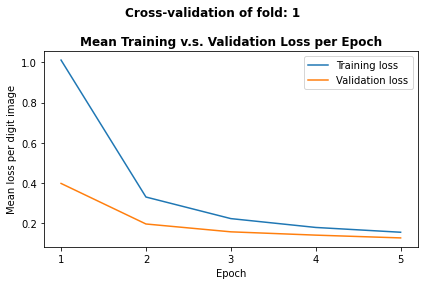

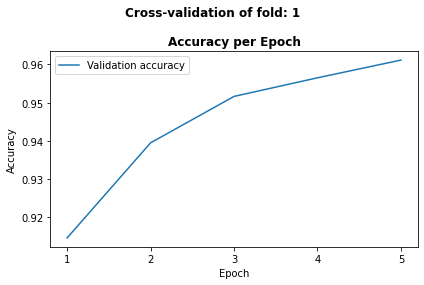

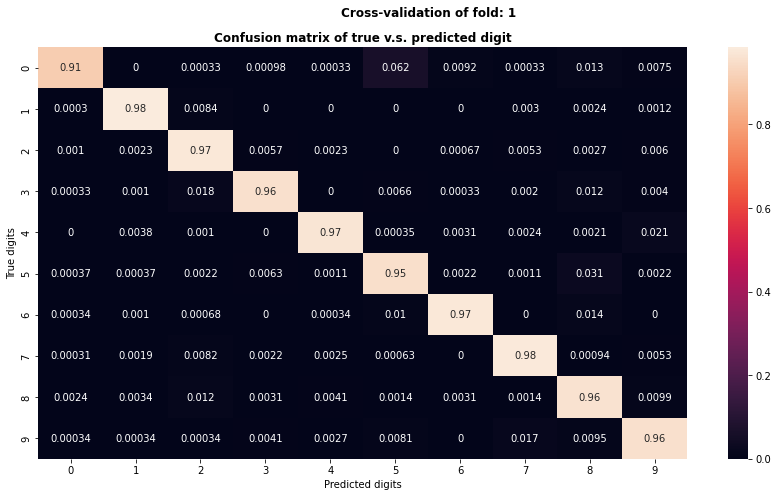


Cross-validating fold: 2
Epoch = 5
Batch size = 32
Epoch	Train Loss	Validate Loss	Validation Accuracy
-----	----------	-------------	-------------------
    1	1.18738   	0.61299      	82.657 %           
    2	0.55475   	0.41994      	85.190 %           
    3	0.43864   	0.37585      	86.160 %           
    4	0.39779   	0.35811      	86.483 %           
    5	0.37570   	0.34243      	86.913 %           



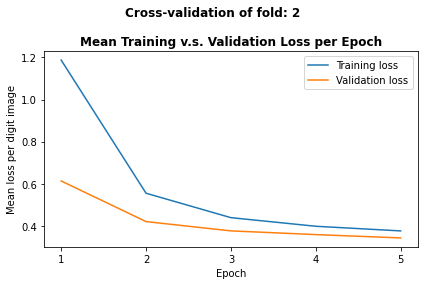

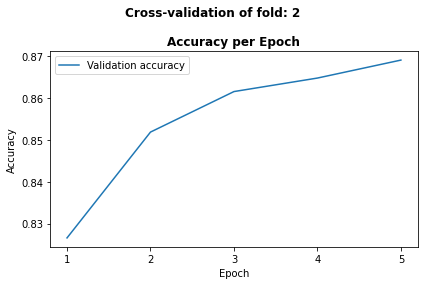

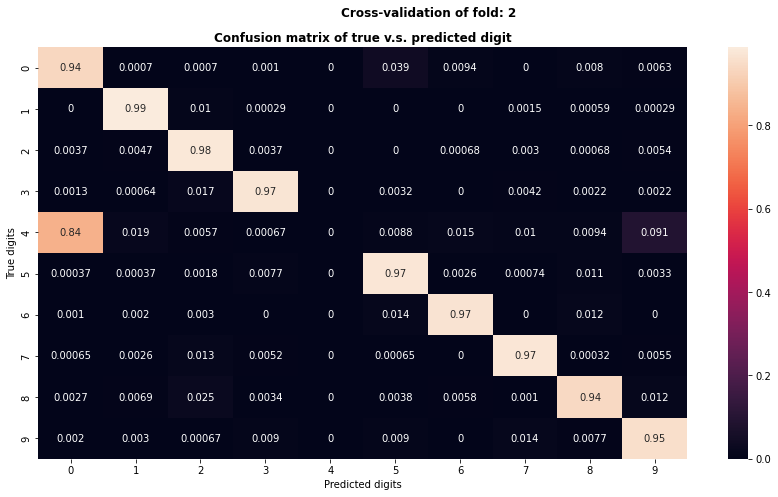


K-Fold Cross-Validation Summary:
Fold 1: Training Loss: 1.9018, Validation Loss: 1.0229
Fold 2: Training Loss: 2.9543, Validation Loss: 2.1093

Mean validation loss across 2 folds: 2.10932
Standard deviation of validation loss across 2 folds: 0.76819



In [174]:
## Compare model configs (with training and k-fold validation)

## Select model, dataset and hyperparameters
dataset = train_dataset
k = 2
batch_size = 32 
epochs = 5

## Hyperparamter configs to test
config_master_lst = [{'optimiser_lr': 1e-5, 
                      'optimiser_weight_decay': 1e-4,
                      'conv_layer_drop0': 0.2,
                      'conv_layer_drop1': 0.2,
                      'conv_layer_drop2': 0.2,
                      'fc_layer_fdrop0': (True, 0.2),
                      'fc_layer_fdrop1': (True, 0.2)
                     },
                    {'optimiser_lr': 1e-5, 
                     'optimiser_weight_decay': 1e-4,
                     'conv_layer_drop0': 0,
                     'conv_layer_drop1': 0,
                     'conv_layer_drop2': 0,
                     'fc_layer_fdrop0': (False, 0),
                     'fc_layer_fdrop1': (False, 0)
                     }]

multiConfigTrainEvalModel(dataset, k, batch_size, epochs, config_master_lst)

**Comment on results:**
  - No neuron dropouts performed better. 
  - No neuron dropouts had:
    - lower mean loss across folds.
    - lower loss standard deviation across folds.
    - better accuracy.
  - For next experiment, try having less layers with dropout.
  - Try some conservative dropout configs to lower mean loss.

### Hyperparameter designs: 
#### Dropout at first FCN layer only 
#### v.s. Dropouts at both FCN layers


Hyperparamaters == {'optimiser_lr': 1e-05, 'optimiser_weight_decay': 0.0001, 'conv_layer_drop0': 0, 'conv_layer_drop1': 0, 'conv_layer_drop2': 0, 'fc_layer_fdrop0': (True, 0.2), 'fc_layer_fdrop1': (False, 0)}

2-fold Cross-Validation

Cross-validating fold: 1
Epoch = 5
Batch size = 32
Epoch	Train Loss	Validate Loss	Validation Accuracy
-----	----------	-------------	-------------------
    1	1.15517   	0.50742      	87.003 %           
    2	0.42523   	0.26375      	92.003 %           
    3	0.28541   	0.19964      	93.960 %           
    4	0.21879   	0.17108      	94.760 %           
    5	0.19314   	0.14416      	95.493 %           



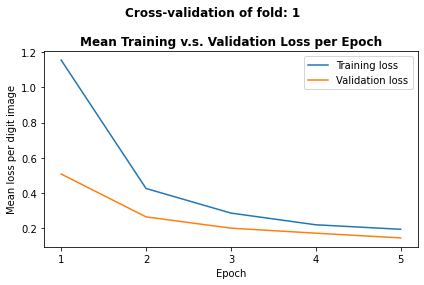

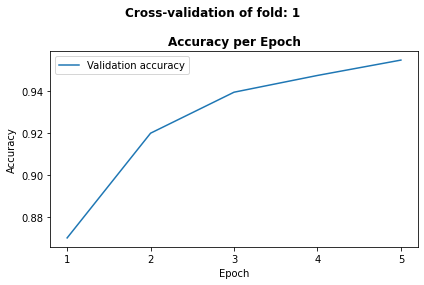

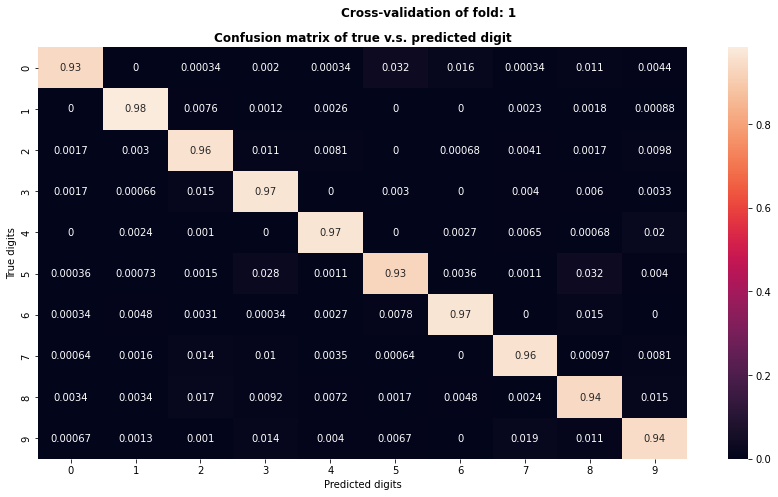


Cross-validating fold: 2
Epoch = 5
Batch size = 32
Epoch	Train Loss	Validate Loss	Validation Accuracy
-----	----------	-------------	-------------------
    1	1.19376   	0.41133      	90.073 %           
    2	0.37829   	0.20280      	93.667 %           
    3	0.25828   	0.16545      	94.793 %           
    4	0.20522   	0.13858      	95.587 %           
    5	0.18618   	0.12706      	96.057 %           



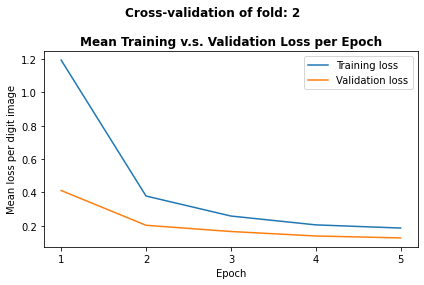

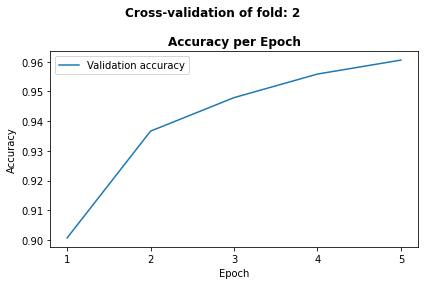

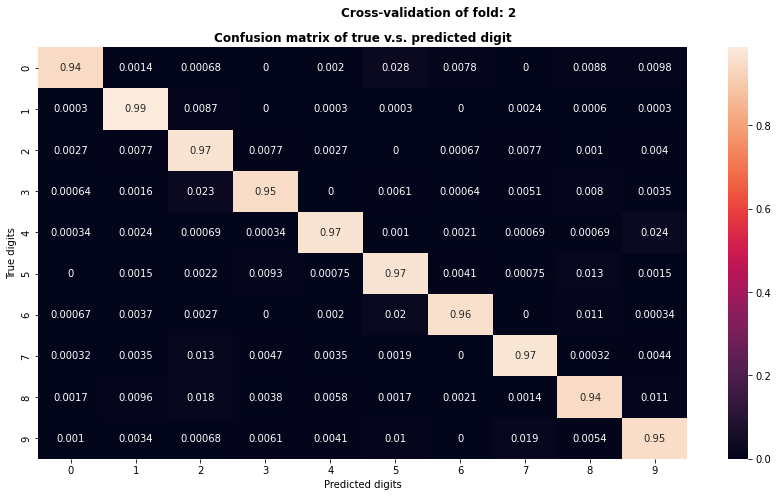


K-Fold Cross-Validation Summary:
Fold 1: Training Loss: 2.2777, Validation Loss: 1.2861
Fold 2: Training Loss: 2.2217, Validation Loss: 1.0452

Mean validation loss across 2 folds: 1.04522
Standard deviation of validation loss across 2 folds: 0.17030


Hyperparamaters == {'optimiser_lr': 1e-05, 'optimiser_weight_decay': 0.0001, 'conv_layer_drop0': 0, 'conv_layer_drop1': 0, 'conv_layer_drop2': 0, 'fc_layer_fdrop0': (True, 0.2), 'fc_layer_fdrop1': (True, 0.2)}

2-fold Cross-Validation

Cross-validating fold: 1
Epoch = 5
Batch size = 32
Epoch	Train Loss	Validate Loss	Validation Accuracy
-----	----------	-------------	-------------------
    1	1.47676   	0.93504      	72.240 %           
    2	0.89779   	0.74808      	75.270 %           
    3	0.77089   	0.67656      	76.977 %           
    4	0.72309   	0.64259      	77.910 %           
    5	0.67959   	0.63068      	77.837 %           



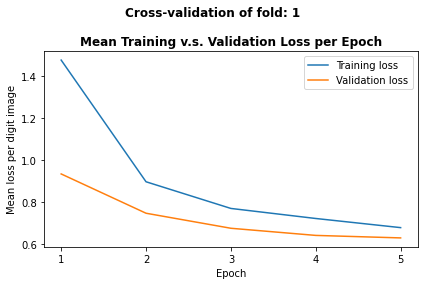

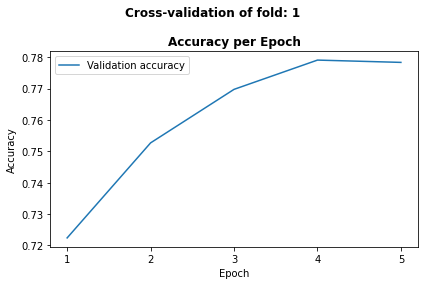

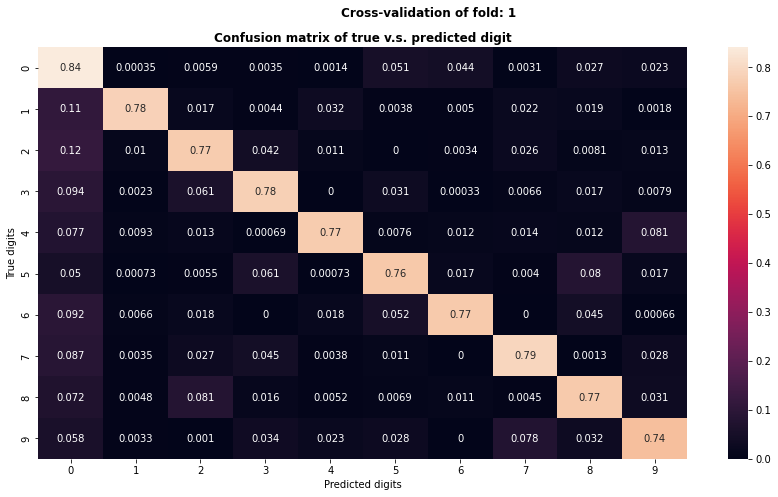


Cross-validating fold: 2
Epoch = 5
Batch size = 32
Epoch	Train Loss	Validate Loss	Validation Accuracy
-----	----------	-------------	-------------------
    1	1.50997   	0.95121      	71.700 %           
    2	0.88931   	0.74538      	75.547 %           
    3	0.76253   	0.67053      	77.227 %           
    4	0.71419   	0.63828      	78.040 %           
    5	0.68540   	0.63878      	77.693 %           



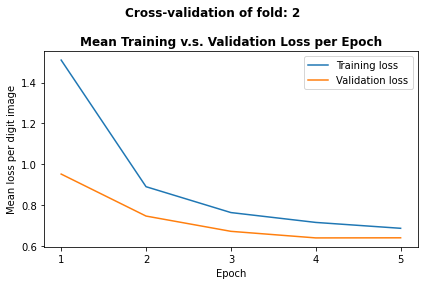

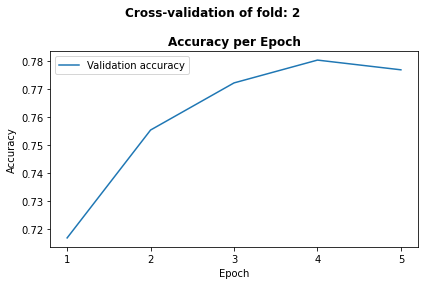

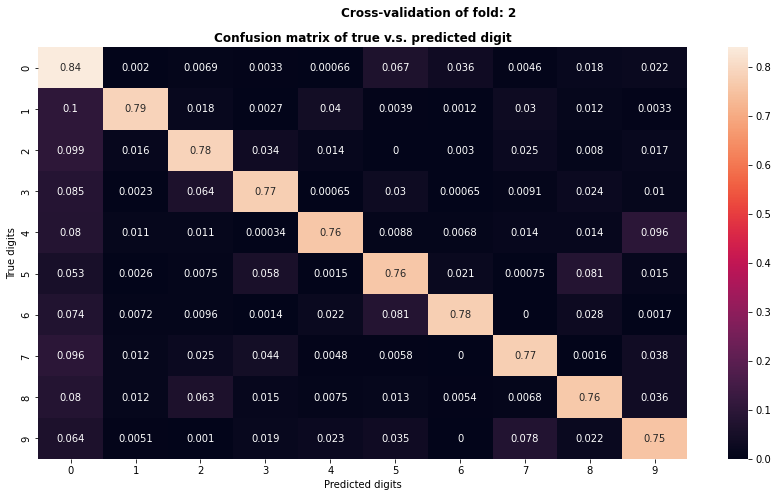


K-Fold Cross-Validation Summary:
Fold 1: Training Loss: 4.5481, Validation Loss: 3.6330
Fold 2: Training Loss: 4.5614, Validation Loss: 3.6442

Mean validation loss across 2 folds: 3.64418
Standard deviation of validation loss across 2 folds: 0.00793



In [177]:
## Select model, dataset and hyperparameters
dataset = train_dataset
k = 2
batch_size = 32 
epochs = 5

## Hyperparamter configs to test
config_master_lst = [
                    {'optimiser_lr': 1e-5,
                     'optimiser_weight_decay': 1e-4,
                     'conv_layer_drop0': 0,
                     'conv_layer_drop1': 0,
                     'conv_layer_drop2': 0,
                     'fc_layer_fdrop0': (True, 0.2),
                     'fc_layer_fdrop1': (False, 0)
                     },
                    {'optimiser_lr': 1e-5, 
                     'optimiser_weight_decay': 1e-4,
                     'conv_layer_drop0': 0,
                     'conv_layer_drop1': 0,
                     'conv_layer_drop2': 0,
                     'fc_layer_fdrop0': (True, 0.2),
                     'fc_layer_fdrop1': (True, 0.2)
                     }]

multiConfigTrainEvalModel(dataset, k, batch_size, epochs, config_master_lst)

**Comment on results:**
  - Only dropout at first FCN layer performed better than previous best model.
  - This model improved in all 3 metrics.
  - For next experiment, fine-tune this model.
  - Try lower dropout probability.
  - Noted that loss and accuracy are about to level-off (with these hyperparameters).
  - Try more epochs. Find epoch where model stops improving.

#### Dropouts at first FCN layer only
#### Use low dropout probability and more epochs


Hyperparamaters == {'optimiser_lr': 1e-05, 'optimiser_weight_decay': 0.0001, 'conv_layer_drop0': 0, 'conv_layer_drop1': 0, 'conv_layer_drop2': 0, 'fc_layer_fdrop0': (True, 0.05), 'fc_layer_fdrop1': (False, 0)}

2-fold Cross-Validation

Cross-validating fold: 1
Epoch = 10
Batch size = 32
Epoch	Train Loss	Validate Loss	Validation Accuracy
-----	----------	-------------	-------------------
    1	1.09681   	0.46333      	88.730 %           
    2	0.36215   	0.21751      	93.643 %           
    3	0.25359   	0.17672      	94.793 %           
    4	0.20240   	0.14327      	95.667 %           
    5	0.17871   	0.14058      	95.697 %           
    6	0.15672   	0.14294      	95.393 %           
    7	0.14624   	0.13068      	95.967 %           
    8	0.13548   	0.11985      	96.277 %           
    9	0.12182   	0.10270      	96.823 %           
   10	0.11602   	0.10723      	96.713 %           



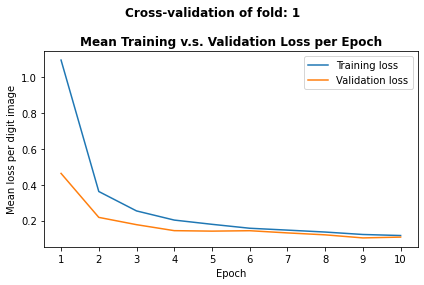

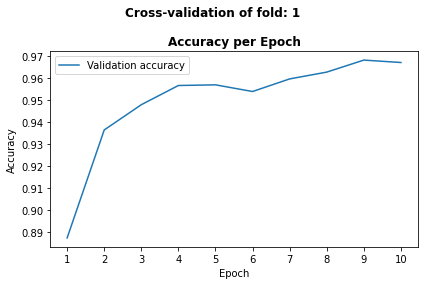

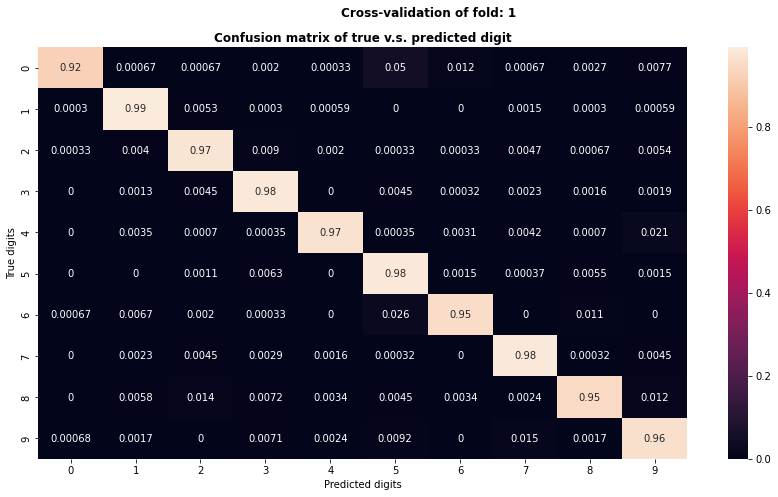


Cross-validating fold: 2
Epoch = 10
Batch size = 32
Epoch	Train Loss	Validate Loss	Validation Accuracy
-----	----------	-------------	-------------------
    1	1.06916   	0.41677      	89.613 %           
    2	0.35036   	0.19914      	93.897 %           
    3	0.23880   	0.15425      	95.147 %           
    4	0.19508   	0.14374      	95.527 %           
    5	0.17263   	0.13244      	95.850 %           
    6	0.15005   	0.12533      	96.113 %           
    7	0.13929   	0.10473      	96.640 %           
    8	0.12476   	0.10799      	96.537 %           
    9	0.11828   	0.09660      	96.730 %           
   10	0.10925   	0.09873      	96.747 %           



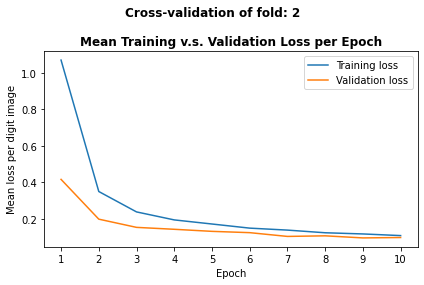

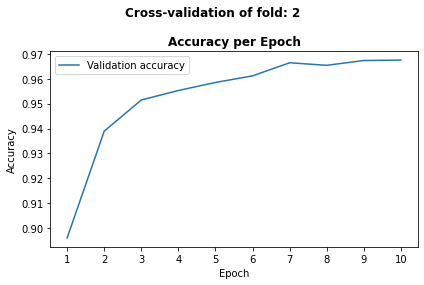

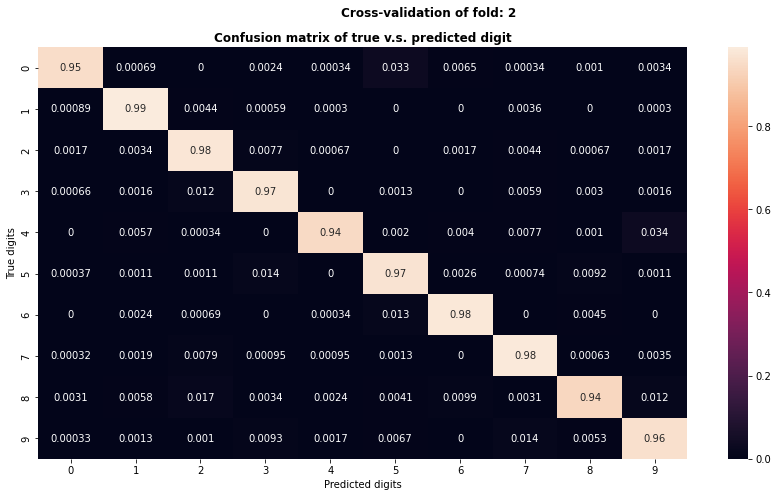


K-Fold Cross-Validation Summary:
Fold 1: Training Loss: 2.7700, Validation Loss: 1.7448
Fold 2: Training Loss: 2.6677, Validation Loss: 1.5797

Mean validation loss across 2 folds: 1.57972
Standard deviation of validation loss across 2 folds: 0.11675



In [178]:
## Select model, dataset and hyperparameters
dataset = train_dataset
k = 2
batch_size = 32
epochs = 10

## Hyperparamter configs to test
config_master_lst = [
                    {'optimiser_lr': 1e-5,
                     'optimiser_weight_decay': 1e-4,
                     'conv_layer_drop0': 0,
                     'conv_layer_drop1': 0,
                     'conv_layer_drop2': 0,
                     'fc_layer_fdrop0': (True, 0.05),
                     'fc_layer_fdrop1': (False, 0)
                     }]

multiConfigTrainEvalModel(dataset, k, batch_size, epochs, config_master_lst)

**Comment on results:**
  - Current model design selected as best model design.
  - Model has stopped improving in loss and accuracy. (At 10 epochs)
  - Final train and validation losses across folds was less than 1.0. (Loss = about 0.1 )
  - Improved loss standard deviation across fold. (Loss std = 0.117)
  - Improved loss standard deviation also supported by convergence of mean training and validation losses
  - Select this model design for cross k-fold training.  

## Cross K-fold training of selected model 

**Design considerations:**
  - Before training, reset selected model. (Prevent leaking learnt weights and gradients)
  - Cross-train model design across K-folds.
  - I.e. Accumulate weight and loss optimiser learning across folds.
  - Objective: minimise overfitting and improve accuracy, using the variation between folds.

### Wrapper function to cross K-fold training of model 

**Design considerations:**
  - Weight and loss optimiser learning were not reset across folds.

In [10]:
## Wrapper function to cross K-fold training of model

def crosskFoldTrainVsVal(model,
                         k,
                         dataset,
                         batch_size,
                         epochs,
                         optimiser,
                         loss_fn,
                         config_dict,
                         optimiser_lr,
                         optimiser_weight_decay):

    kf = KFold(n_splits=k, shuffle=True, random_state=None)

    ## List to store train and evaluate losses from each fold
    fold_loss_lst = []

    ## Initialise accumulator
    total_evaluate_loss = 0
    fold_count = 0

    ## Print k fold header
    print()
    print(f"{k}-fold Cross-training")

    for train_index, evaluate_index in kf.split(dataset):

        train_subset = torch.utils.data.Subset(dataset, train_index)
        evaluate_subset = torch.utils.data.Subset(dataset, evaluate_index)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        evaluate_loader = DataLoader(evaluate_subset, shuffle=True)

        ## Print fold header
        print()
        fold_count += 1
        print(f"Cross-validating fold: {fold_count}")

        ## Initialise list to store mean losses per epoch
        mean_train_loss_per_epoch_lst = []
        mean_evaluate_loss_per_epoch_lst = []

        ## Initialise list to store accuracy per epoch
        accuracy_lst = []

        ## Get fold train and evaluate losses
        fold_train_eval = trainVsEvalModel(model,
                                           train_loader,
                                           epochs,
                                           optimiser,
                                           loss_fn,
                                           mean_train_loss_per_epoch_lst,
                                           evaluate_loader,
                                           mean_train_loss_per_epoch_lst,
                                           accuracy_lst,
                                           fold_count)

        fold_train_loss, fold_evaluate_loss = fold_train_eval

        fold_loss_lst.append((fold_train_loss, fold_evaluate_loss))

    ## Print final summary
    print()
    print("Cross K-Fold Training Summary:")

    fold_evaluate_loss_lst = []
    for fold, (train_loss, val_loss) in enumerate(fold_loss_lst):
        print(f"Fold {fold+1}: Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        total_evaluate_loss += fold_evaluate_loss
        fold_evaluate_loss_lst.append(val_loss)

    mean_kfold_evaluate_loss = total_evaluate_loss / k
    std_kfold_evaluate_loss = np.std(fold_evaluate_loss_lst, ddof = k-1)

    return mean_kfold_evaluate_loss, std_kfold_evaluate_loss

## Wrapper to support multi-config cross-training
def multiConfigCrossTrainEvalModel(dataset, k, batch_size, epochs, config_master_lst):
    for config_dict in config_master_lst:
        print()
        print(f"Hyperparamaters == {config_dict}")

        sub_config_dict = {}
        for key, value in config_dict.items():
            if 'optim' not in key:
                sub_config_dict[key] = value

        model = CNN(**sub_config_dict)

        optimiser_lr = config_dict['optimiser_lr']
        optimiser_weight_decay = config_dict['optimiser_weight_decay']

        optimiser = optim.Adam(model.parameters(),
                               lr = optimiser_lr,
                               weight_decay = optimiser_weight_decay)

        loss_fn = nn.CrossEntropyLoss()


        ## Mean and std loss for k folds
        mean_kfold_evaluate_loss, std_kfold_evaluate_loss = crosskFoldTrainVsVal(model, 
                                                                                 k, 
                                                                                 dataset, 
                                                                                 batch_size, 
                                                                                 epochs, 
                                                                                 optimiser, 
                                                                                 loss_fn, 
                                                                                 config_dict, 
                                                                                 optimiser_lr, 
                                                                                 optimiser_weight_decay)

        ## Summary of k fold validation
        print()
        print(f"Mean validation loss across {k} folds: {mean_kfold_evaluate_loss:.5f}")
        print(f"Standard deviation of validation loss across {k} folds: {std_kfold_evaluate_loss:.5f}")
        print()

    torch.save(model.state_dict(), 'cnn_model_a.pth') 



### Cross K-fold training


Hyperparamaters == {'optimiser_lr': 1e-05, 'optimiser_weight_decay': 0.0001, 'conv_layer_drop0': 0, 'conv_layer_drop1': 0, 'conv_layer_drop2': 0, 'fc_layer_fdrop0': (True, 0.05), 'fc_layer_fdrop1': (False, 0)}

5-fold Cross-training

Cross-validating fold: 1
Epoch = 10
Batch size = 32
Epoch	Train Loss	Validate Loss	Validation Accuracy
-----	----------	-------------	-------------------
    1	0.86421   	0.31077      	92.050 %           
    2	0.26972   	0.15475      	95.333 %           
    3	0.18427   	0.14542      	95.333 %           
    4	0.15357   	0.13355      	95.808 %           
    5	0.13604   	0.11208      	96.533 %           
    6	0.11901   	0.10360      	96.725 %           
    7	0.10967   	0.09019      	97.275 %           
    8	0.10429   	0.08658      	97.275 %           
    9	0.09578   	0.07831      	97.567 %           
   10	0.09071   	0.07747      	97.500 %           



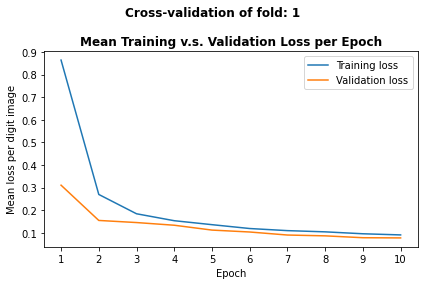

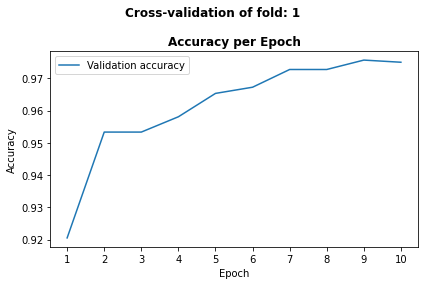

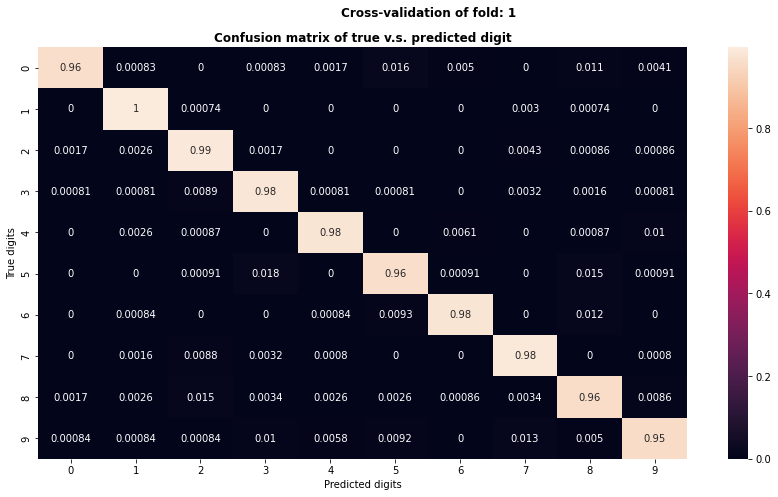


Cross-validating fold: 2
Epoch = 10
Batch size = 32
Epoch	Train Loss	Validate Loss	Validation Accuracy
-----	----------	-------------	-------------------
    1	0.15384   	0.09898      	97.358 %           
    2	0.10395   	0.07441      	97.667 %           
    3	0.09446   	0.07012      	97.742 %           
    4	0.08602   	0.06894      	97.817 %           
    5	0.07978   	0.06158      	98.075 %           
    6	0.07667   	0.05712      	98.242 %           
    7	0.07289   	0.05573      	98.267 %           
    8	0.06975   	0.05333      	98.442 %           
    9	0.06567   	0.05401      	98.275 %           
   10	0.06300   	0.05360      	98.250 %           



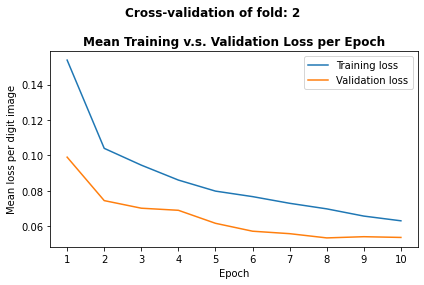

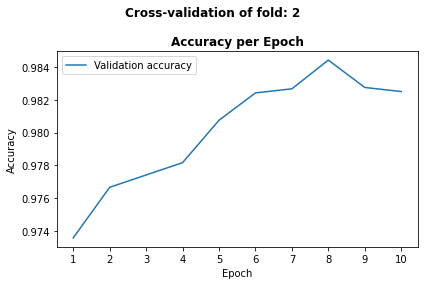

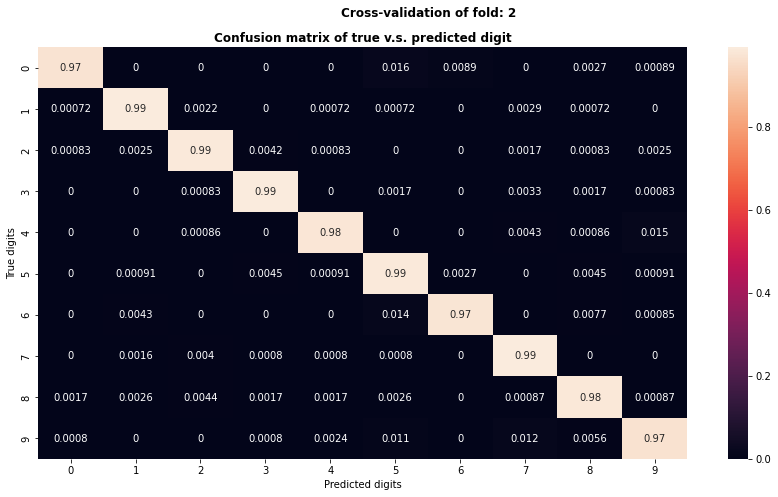


Cross-validating fold: 3
Epoch = 10
Batch size = 32
Epoch	Train Loss	Validate Loss	Validation Accuracy
-----	----------	-------------	-------------------
    1	0.09564   	0.06199      	98.325 %           
    2	0.07390   	0.04845      	98.500 %           
    3	0.06669   	0.04823      	98.367 %           
    4	0.06388   	0.04507      	98.508 %           
    5	0.06177   	0.04676      	98.442 %           
    6	0.05932   	0.04239      	98.600 %           
    7	0.05595   	0.04146      	98.583 %           
    8	0.05679   	0.04250      	98.558 %           
    9	0.05397   	0.04155      	98.650 %           
   10	0.05185   	0.04075      	98.650 %           



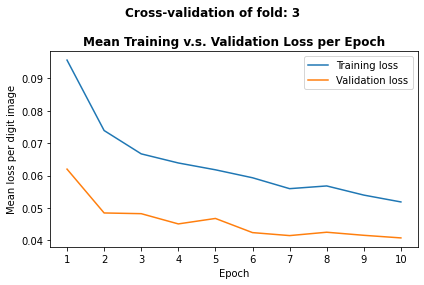

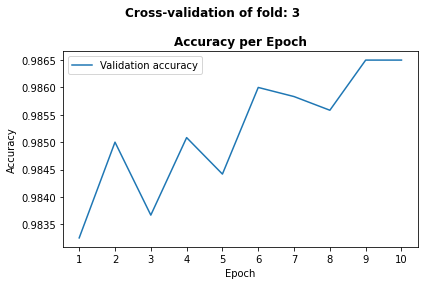

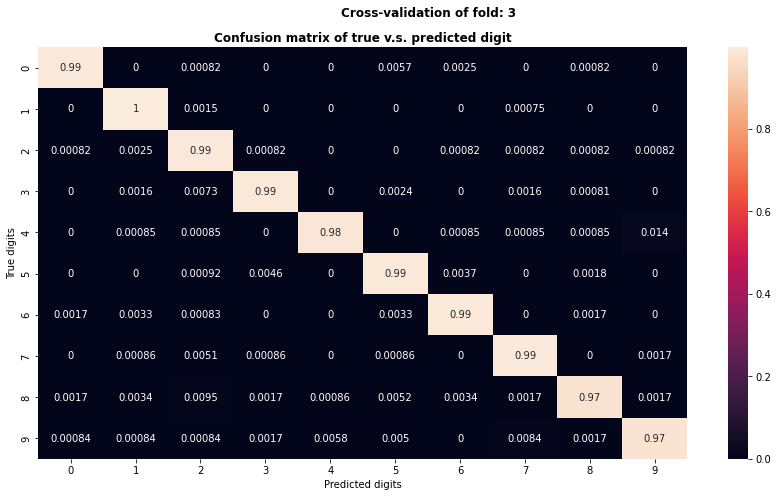


Cross-validating fold: 4
Epoch = 10
Batch size = 32
Epoch	Train Loss	Validate Loss	Validation Accuracy
-----	----------	-------------	-------------------
    1	0.07342   	0.05124      	98.692 %           
    2	0.05914   	0.04292      	98.600 %           
    3	0.05739   	0.04173      	98.617 %           
    4	0.05256   	0.04143      	98.658 %           
    5	0.04985   	0.04199      	98.650 %           
    6	0.05031   	0.03647      	98.817 %           
    7	0.04811   	0.03895      	98.700 %           
    8	0.04647   	0.04040      	98.675 %           
    9	0.04733   	0.04241      	98.567 %           
   10	0.04565   	0.03675      	98.767 %           



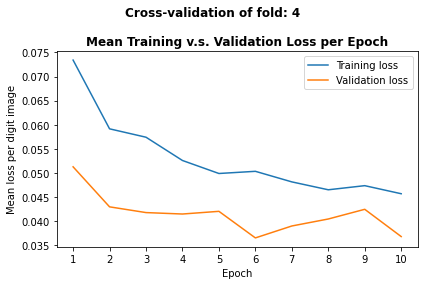

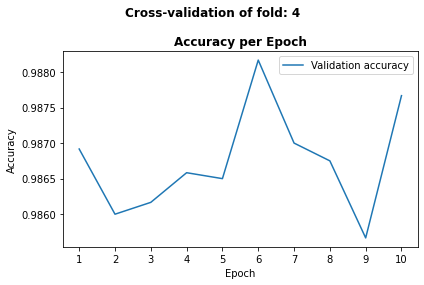

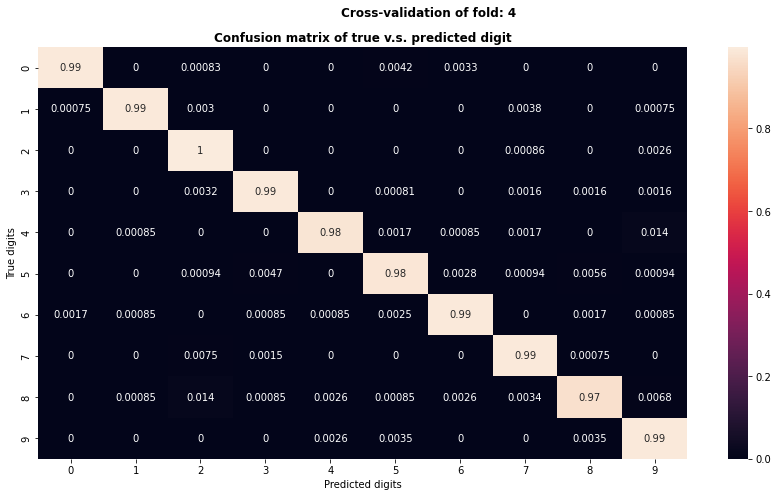


Cross-validating fold: 5
Epoch = 10
Batch size = 32
Epoch	Train Loss	Validate Loss	Validation Accuracy
-----	----------	-------------	-------------------
    1	0.06142   	0.04206      	98.850 %           
    2	0.04981   	0.03855      	98.842 %           
    3	0.04611   	0.03650      	98.900 %           
    4	0.04539   	0.03808      	98.858 %           
    5	0.04354   	0.03504      	98.867 %           
    6	0.04192   	0.03596      	98.875 %           
    7	0.04245   	0.03618      	98.908 %           
    8	0.04058   	0.03457      	98.975 %           
    9	0.03987   	0.03521      	98.908 %           
   10	0.03955   	0.03153      	99.067 %           



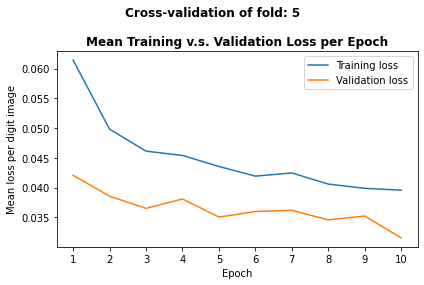

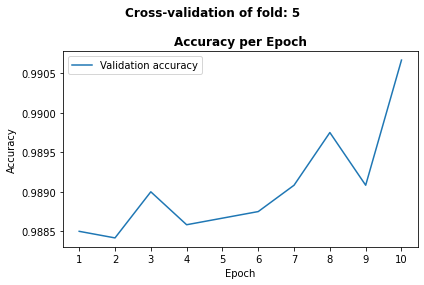

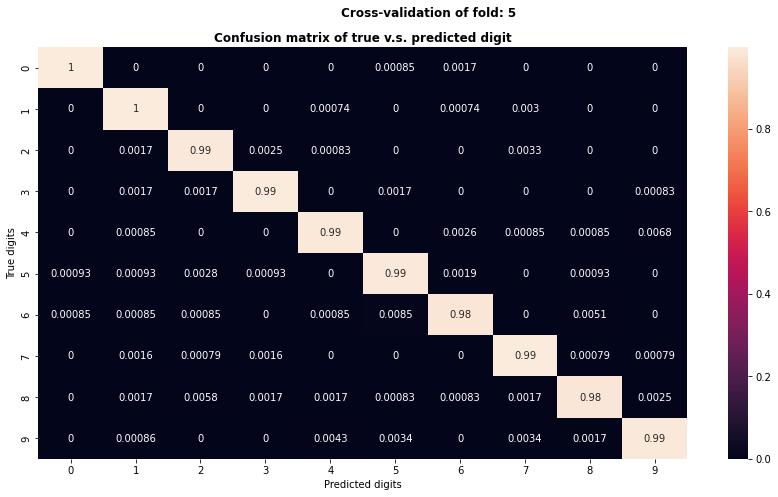


Cross K-Fold Training Summary:
Fold 1: Training Loss: 2.1273, Validation Loss: 1.2927
Fold 2: Training Loss: 0.8660, Validation Loss: 0.6478
Fold 3: Training Loss: 0.6397, Validation Loss: 0.4591
Fold 4: Training Loss: 0.5302, Validation Loss: 0.4143
Fold 5: Training Loss: 0.4506, Validation Loss: 0.3637

Mean validation loss across 5 folds: 0.36368
Standard deviation of validation loss across 5 folds: 0.76550



In [180]:
## Select model, dataset and hyperparameters
dataset = train_dataset
k = 5
batch_size = 32
epochs = 10

## Hyperparamter configs to train
config_master_lst = [
                    {'optimiser_lr': 1e-5,
                     'optimiser_weight_decay': 1e-4,
                     'conv_layer_drop0': 0,
                     'conv_layer_drop1': 0,
                     'conv_layer_drop2': 0,
                     'fc_layer_fdrop0': (True, 0.05),
                     'fc_layer_fdrop1': (False, 0)
                     },
                    ]

multiConfigCrossTrainEvalModel(dataset, k, batch_size, epochs, config_master_lst)

## Testing performance of cross K-fold trained model
### (Testing on unseen test dataset)

### Load test dataset into model for classification

In [11]:
## Load hyperparamter into model architecture
hyperparameter_dict= {'conv_layer_drop0': 0,
                     'conv_layer_drop1': 0,
                     'conv_layer_drop2': 0,
                     'fc_layer_fdrop0': (True, 0.05),
                     'fc_layer_fdrop1': (False, 0)
                     }
model = CNN(**hyperparameter_dict) 

## Load the saved state dict for weights
state_dict = torch.load('cnn_model_a.pth')
model.load_state_dict(state_dict)
model.to(device)

## Evaluate
loss_fn = nn.CrossEntropyLoss()
evaluate_dataset = test_dataset
evaluate_loader = DataLoader(evaluate_dataset, batch_size=32, shuffle=False)
accuracy, mean_evaluate_loss, true_lst, predictions_lst = evalModel(model, evaluate_loader, loss_fn)




In [12]:
## Function to print classification metrics

def classifyScore(true_lst, predictions_lst):
    precision = precision_score(true_lst, predictions_lst, average = 'micro')
    recall = recall_score(true_lst, predictions_lst, average = 'micro')
    f1 = f1_score(true_lst, predictions_lst, average = 'micro')
    
    print(f"Mean loss per digit image: {round(mean_evaluate_loss, 4)}") 
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    print(f"Accuracy: {accuracy}")




### Result


Mean loss per digit image: 0.001
Precision: 0.9889
Recall: 0.9889
F1: 0.9889
Accuracy: 0.9889




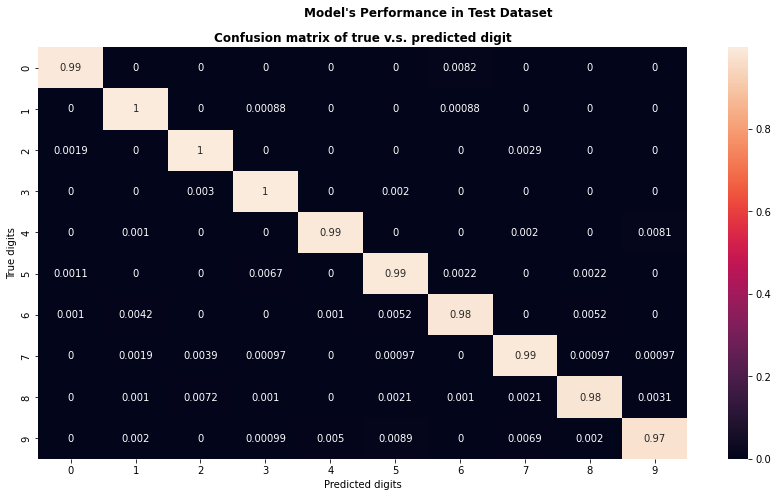

In [30]:
## Classification metric result

true_lst, predictions_lst = torch.cat(true_lst), torch.cat(predictions_lst) 
true_lst, predictions_lst = true_lst.numpy(), predictions_lst.numpy() 

print()
classifyScore(true_lst, predictions_lst)

print()
plotConfusionMatrix(len(true_lst), true_lst, predictions_lst, "Model's Performance in Test Dataset")


## Conclusion of results
  - CNN model developed was very successful in classifying handwritten digits
  - Model achieved goal of high accuracy and F1. (Both 0.9889)
  - High performance achieved with **shallow CNN** and **10 training epochs**.
    - Shallow CNN: 3 CNN layers plus 2 FCN layers.
    - 10 training epochs:
      - 60,000 training samples (standard size)
      - Trained with 5 folds
      - Mini-batch size of 32
      - Total iterations: 18,750

## MODEL SANITY CHECK 
### (Images v.s. predicted digit)


MODEL SANITY CHECK on TEST DATASET
Showing classification of first 16 images


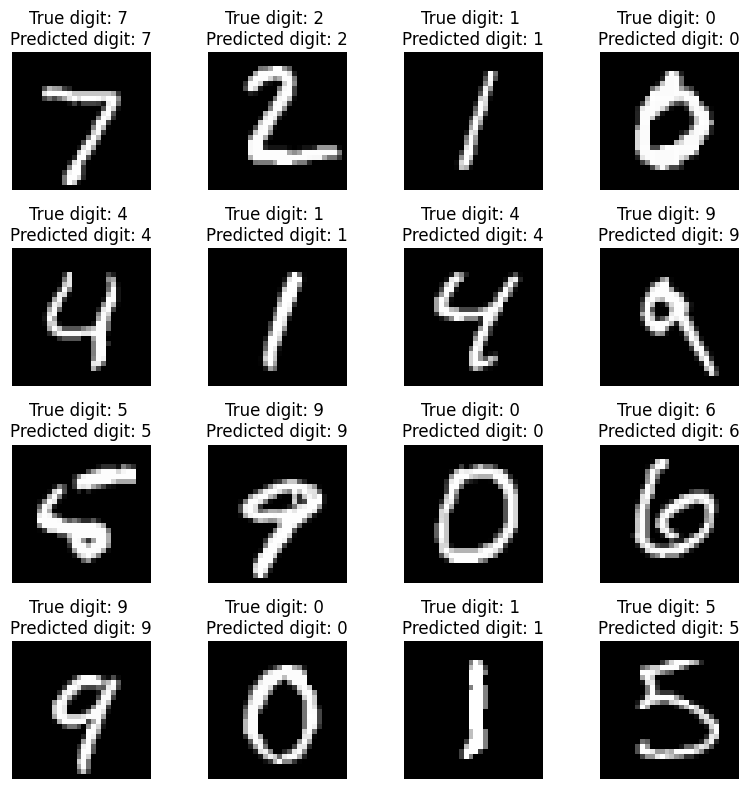

In [13]:
print()
print('''MODEL SANITY CHECK on TEST DATASET''')
print('''Showing classification of first 16 images''')


num_image = 16

model.to(device)
model.eval()

x_eval = []
y_eval = []

test_loader = DataLoader(test_dataset, shuffle=False)

with torch.no_grad():
    for x, y in test_loader:
        x = x / 255
        x = x.to(device)
        x_eval.append(x)
        y_eval.append(y)
        
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

## Flattening the axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes):
    digit = model(x_eval[i])
    _, predictions = torch.max(digit, 1)
    ax.set_title(f'True digit: {y_eval[i].item()} \nPredicted digit: {predictions[0].item()}')
    ax.imshow(x_eval[i].cpu().numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')  

plt.tight_layout()  
plt.show()